## Setup the Env

In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## Load Data

In [3]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [4]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [5]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_clustering.parquet")

In [6]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,16,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,16,0.010933,0.009348
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,16,-0.001095,0.000711
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,16,0.000353,0.002520
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,16,0.001616,0.002617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064,14,-0.001462,0.004559
809879,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064,14,0.006872,0.006860
809880,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064,14,0.000384,0.000932
809881,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064,14,-0.004950,-0.001311


In [7]:
df.dtypes

date                               datetime64[ns]
permno_id                                  object
ncusip_id                                  object
cusip_id                                   object
ticker                                     object
share_code                                 object
share_code_type                            object
share_code_detail                          object
exchange_code                              object
company_name                               object
primary_exchange                           object
trading_status                             object
security_status                            object
naics                                      object
naics_sector                               object
naics_secondary                            object
ask_or_high_price                         float64
ask_price                                 float64
bid_or_low_price                          float64
bid_price                                 float64


In [8]:
max(df.groupby("permno_id")["ticker"].nunique())

3

In [9]:
# Group by 'PERMNO' and count unique 'TICKER', then filter for those with exactly 2 unique 'TICKER'
permno_with_multiple_tickers = df.groupby("permno_id")["ticker"].nunique()
permno_with_multiple_tickers = permno_with_multiple_tickers[permno_with_multiple_tickers == 2].index

# Display the PERMNO values
# data[data['PERMNO'].isin(permno_with_multiple_tickers)]
permno_with_multiple_tickers

Index(['10696', '12431', '13407', '14882', '16048', '16692', '16851', '17830',
       '19751', '24053', '24643', '25582', '42200', '52329', '57568', '62308',
       '64282', '67598', '71563', '75034', '76082', '81540', '82303', '86783',
       '89017', '89179', '90199', '90441', '90442', '91277'],
      dtype='object', name='permno_id')

In [10]:
df[df["permno_id"].isin(permno_with_multiple_tickers)]

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
7545,2018-01-02,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,-0.005966,2.706066e+07,3.527358e+09,0.000000,0.000000,-0.0,-0.00064,0,0.000000,0.000000
7546,2018-01-03,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.008099,2.728072e+07,3.584959e+09,0.021973,0.005694,0.0,-0.00064,0,0.016240,0.008609
7547,2018-01-04,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.013980,2.766477e+07,3.686607e+09,0.002940,0.001681,0.0,-0.00064,0,0.001434,0.003193
7548,2018-01-05,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.009857,2.793881e+07,3.760005e+09,0.015718,0.004005,0.0,-0.00064,0,0.012690,0.007990
7549,2018-01-08,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.002004,2.799486e+07,3.775107e+09,0.006267,0.009789,0.0,-0.00064,0,0.005395,0.004423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775171,2023-12-22,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,-0.017352,3.305973e+05,2.870907e+05,0.003961,0.005242,-0.0,-0.00064,14,-0.001462,0.004559
775172,2023-12-26,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.000346,3.307115e+05,2.872891e+05,0.003031,0.004622,0.0,-0.00064,14,0.006872,0.006860
775173,2023-12-27,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,-0.001037,3.303689e+05,2.866941e+05,-0.002365,0.007425,-0.0,-0.00064,14,0.000384,0.000932
775174,2023-12-28,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.030863,3.407238e+05,3.049478e+05,-0.000601,0.003489,0.0,-0.00064,14,-0.004950,-0.001311


## Feature Engineering

In [11]:
data_1 = df[
    [
        "date",
        "permno_id",
        "naics",
        "log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "cluster_weighted_avg_log_return",
        "cluster_simple_avg_log_return",
    ]
]
data_1

,date,permno_id,naics,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,511210.0,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,511210.0,0.022897,0.021973,0.005694,0.0,-0.00064,0.010933,0.009348
2,2018-01-04,10104,511210.0,0.009803,0.002940,0.001681,0.0,-0.00064,-0.001095,0.000711
3,2018-01-05,10104,511210.0,0.006001,0.015718,0.004005,0.0,-0.00064,0.000353,0.002520
4,2018-01-08,10104,511210.0,0.010467,0.006267,0.009789,0.0,-0.00064,0.001616,0.002617
...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,336110.0,-0.007731,-0.001753,0.016253,-0.0,-0.00064,-0.001462,0.004559
809879,2023-12-26,93436,336110.0,0.015988,0.006185,0.001010,0.0,-0.00064,0.006872,0.006860
809880,2023-12-27,93436,336110.0,0.018647,0.003881,0.001242,0.0,-0.00064,0.000384,0.000932
809881,2023-12-28,93436,336110.0,-0.032104,-0.002012,0.004141,-0.0,-0.00064,-0.004950,-0.001311


In [12]:
data_1["naics_sector_digits"] = data_1["naics"].astype(str).str[:2]
data_1

/tmp/ipykernel_163/281497084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1["naics_sector_digits"] = data_1["naics"].astype(str).str[:2]


,date,permno_id,naics,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return,naics_sector_digits
0,2018-01-02,10104,511210.0,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000,51
1,2018-01-03,10104,511210.0,0.022897,0.021973,0.005694,0.0,-0.00064,0.010933,0.009348,51
2,2018-01-04,10104,511210.0,0.009803,0.002940,0.001681,0.0,-0.00064,-0.001095,0.000711,51
3,2018-01-05,10104,511210.0,0.006001,0.015718,0.004005,0.0,-0.00064,0.000353,0.002520,51
4,2018-01-08,10104,511210.0,0.010467,0.006267,0.009789,0.0,-0.00064,0.001616,0.002617,51
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,336110.0,-0.007731,-0.001753,0.016253,-0.0,-0.00064,-0.001462,0.004559,33
809879,2023-12-26,93436,336110.0,0.015988,0.006185,0.001010,0.0,-0.00064,0.006872,0.006860,33
809880,2023-12-27,93436,336110.0,0.018647,0.003881,0.001242,0.0,-0.00064,0.000384,0.000932,33
809881,2023-12-28,93436,336110.0,-0.032104,-0.002012,0.004141,-0.0,-0.00064,-0.004950,-0.001311,33


In [13]:
data_2 = data_1[
    [
        "date",
        "permno_id",
        "naics_sector_digits",
        "log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "cluster_weighted_avg_log_return",
        "cluster_simple_avg_log_return",
    ]
]
data_2

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.010933,0.009348
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,-0.001095,0.000711
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.000353,0.002520
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.001616,0.002617
...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,33,-0.007731,-0.001753,0.016253,-0.0,-0.00064,-0.001462,0.004559
809879,2023-12-26,93436,33,0.015988,0.006185,0.001010,0.0,-0.00064,0.006872,0.006860
809880,2023-12-27,93436,33,0.018647,0.003881,0.001242,0.0,-0.00064,0.000384,0.000932
809881,2023-12-28,93436,33,-0.032104,-0.002012,0.004141,-0.0,-0.00064,-0.004950,-0.001311


## Model-Phase 2

In [14]:
data = data_2

In [15]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
train_data = data[data["date"] <= "2022-12-31"]
validation_data = data[data["date"] > "2022-12-31"]

In [16]:
first_month_data = data[data["date"] < "2018-02-01"]
first_month_data

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.010933,0.009348
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,-0.001095,0.000711
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.000353,0.002520
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.001616,0.002617
...,...,...,...,...,...,...,...,...,...,...
808390,2018-01-25,93436,33,-0.024141,0.003783,0.002743,-0.0,-0.00064,0.017231,0.003165
808391,2018-01-26,93436,33,0.015313,0.009715,0.012428,0.0,-0.00064,0.020251,0.011786
808392,2018-01-29,93436,33,0.019297,-0.007773,-0.004058,0.0,-0.00064,0.012989,-0.005149
808393,2018-01-30,93436,33,-0.010671,-0.008697,-0.020804,-0.0,-0.00064,0.017730,-0.007408


### Check and make sure no missing values

In [17]:
first_month_data.dtypes

date                               datetime64[ns]
permno_id                                  object
naics_sector_digits                        object
log_return                                float64
sector_weighted_avg_log_return            float64
sector_simple_avg_log_return              float64
weighted_avg_log_return                   float64
simple_avg_log_return                     float64
cluster_weighted_avg_log_return           float64
cluster_simple_avg_log_return             float64
dtype: object

In [18]:
first_month_data[first_month_data["log_return"].isnull() == 1]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return


In [19]:
first_month_data[first_month_data["date"].isnull() == 1]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return


In [20]:
first_month_data.isnull().sum()

date                               0
permno_id                          0
naics_sector_digits                0
log_return                         0
sector_weighted_avg_log_return     0
sector_simple_avg_log_return       0
weighted_avg_log_return            0
simple_avg_log_return              0
cluster_weighted_avg_log_return    0
cluster_simple_avg_log_return      0
dtype: int64

In [21]:
len(first_month_data)

11025

### Build Model & Get Embedding
1. The current model uses positional encodings.
2. Need to add ordinal position for each return.
3. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
4. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

#### Model-2 (+naics_sector)
Features:   
'log_return'  
'naics_sector_digits'  
'+' 'postional encoding' 

In [21]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.010933,0.009348
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,-0.001095,0.000711
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.000353,0.002520
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.001616,0.002617
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.001853,-0.002597
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.006719,0.008038
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.013420,0.006509
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.012179,-0.000539


/tmp/ipykernel_264/2208888312.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[["log_return", "naics_sector_digits"]] = self.data[["log_return", "naics_sector_digits"]].apply(
/tmp/ipykernel_264/2208888312.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[["log_return", "naics_sector_digits"]] = self.data[["log_return", "naics_sector_digits"]].apply(


Epoch 1/5, Training Loss: 0.02109523804891694, Validation Loss: 0.012345270443048964
Epoch 2/5, Training Loss: 0.016211603836567577, Validation Loss: 0.012812072448546022
Epoch 3/5, Training Loss: 0.016097880091258322, Validation Loss: 0.012312156466721761
Epoch 4/5, Training Loss: 0.016063590004198745, Validation Loss: 0.012345861480230601
Epoch 5/5, Training Loss: 0.01605924383393766, Validation Loss: 0.012342651952512381
Training Complete


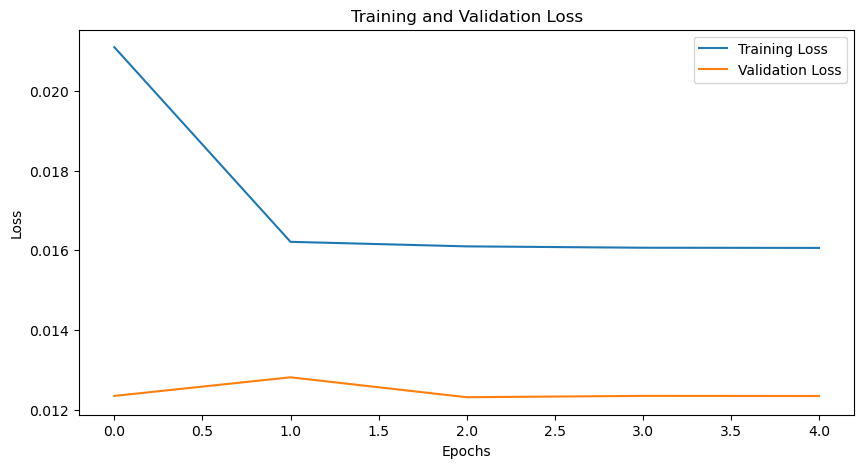

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128):
        self.data = data
        self.window_size = window_size
        self.data[["log_return", "naics_sector_digits"]] = self.data[["log_return", "naics_sector_digits"]].apply(
            pd.to_numeric, errors="coerce"
        )
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = group[["log_return", "naics_sector_digits"]].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
# dataset = FinancialDataset(first_month_data[:100])
# dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=128 * 2 + 1, embed_dim=256, n_heads=16, ff_dim=1024, n_layers=6)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

# for epoch in range(1):
#     for batch in dataloader:
#         optimizer.zero_grad()
#         output, _ = model(batch["features"])
#         loss = criterion(output, batch["target"])
#         # print(f'loss: {loss}')
#         loss.backward()
#         optimizer.step()

# print("Training Complete")

train_losses = []
val_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"])
            loss = criterion(output, batch["target"])
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [24]:
dataloader = train_dataloader
dataset = train_dataset

In [25]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [26]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [27]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-6.10343134e-03, -5.31168934e-03, -1.16676893e-02, -5.06957900e-03,
         -6.86098170e-03,  2.46981299e-03, -7.42627773e-04, -1.25786643e-02,
          7.16268492e-04,  5.02294023e-03, -8.57259706e-03, -8.55716597e-03,
         -3.28490860e-03, -1.05238929e-02, -4.53039259e-03,  4.45529167e-03,
         -1.57271896e-03, -5.65707590e-03, -9.10768285e-03, -2.43968982e-02,
          7.21708359e-03, -8.43954273e-03,  1.18356999e-02,  1.62612752e-03,
          2.52388068e-03, -1.03888602e-03, -4.48727806e-04, -5.16792107e-03,
         -1.36861252e-03, -1.15306871e-02, -7.56247568e+00,  8.30459129e-03,
          1.27860601e-03, -5.71640534e-03, -8.99917167e-03, -1.82652054e-03,
          2.19191276e-02,  7.24130249e+00,  1.90912280e-03,  2.80982209e-03,
         -1.64965983e-03, -1.15305791e-02, -5.82739757e-03, -1.81540067e-03,
         -9.20249242e-03, -7.39680836e-03,  6.53076265e-03,  4.74456558e-03,
          9.61241312e-03, -1.13758929e-02, -5.97441685e-05, -4.98

##### Model Features Check

In [28]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01,  2.2897e-02,  ...,  1.5311e-02,
          5.1000e+01,  1.2800e+02],
        [ 2.2897e-02,  5.1000e+01,  9.8028e-03,  ...,  1.2909e-02,
          5.1000e+01,  1.2900e+02],
        [ 9.8028e-03,  5.1000e+01,  6.0010e-03,  ...,  1.5745e-02,
          5.1000e+01,  1.3000e+02],
        ...,
        [ 7.0362e-03,  5.1000e+01,  1.9605e-02,  ..., -8.1189e-03,
          5.1000e+01,  1.5700e+02],
        [ 1.9605e-02,  5.1000e+01,  2.3780e-02,  ...,  5.4203e-03,
          5.1000e+01,  1.5800e+02],
        [ 2.3780e-02,  5.1000e+01,  1.3810e-03,  ...,  5.3904e-03,
          5.1000e+01,  1.5900e+02]]), 'target': tensor([ 0.0129,  0.0157,  0.0055,  0.0137,  0.0106,  0.0099,  0.0004,  0.0090,
        -0.0053, -0.0041,  0.0017,  0.0031,  0.0000,  0.0057, -0.0016, -0.0049,
        -0.0187, -0.0010, -0.0069,  0.0115,  0.0118,  0.0041, -0.0039, -0.0019,
         0.0031, -0.0045, -0.0064,  0.0046, -0.0081,  0.0054,  0.0054,  0.0012]), 'permno_id': ['10104',

In [29]:
batch["features"].shape

torch.Size([32, 257])

In [30]:
batch["target"].shape

torch.Size([32])

In [31]:
len(batch["permno_id"])

32

In [32]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01,  2.2897e-02,  ...,  1.5311e-02,
          5.1000e+01,  1.2800e+02],
        [ 2.2897e-02,  5.1000e+01,  9.8028e-03,  ...,  1.2909e-02,
          5.1000e+01,  1.2900e+02],
        [ 9.8028e-03,  5.1000e+01,  6.0010e-03,  ...,  1.5745e-02,
          5.1000e+01,  1.3000e+02],
        [ 6.0010e-03,  5.1000e+01,  1.0467e-02,  ...,  5.5486e-03,
          5.1000e+01,  1.3100e+02],
        [ 1.0467e-02,  5.1000e+01,  5.4969e-03,  ...,  1.3738e-02,
          5.1000e+01,  1.3200e+02]])

In [33]:
model(batch["features"])

(tensor([0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
         0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
         0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
         0.0019, 0.0019, 0.0019, 0.0019, 0.0019], grad_fn=<SqueezeBackward1>),
 tensor([[-0.0061, -0.0053, -0.0117,  ..., -0.0055, -0.0045,  0.0061],
         [-0.0061, -0.0053, -0.0117,  ..., -0.0055, -0.0045,  0.0061],
         [-0.0061, -0.0053, -0.0117,  ..., -0.0055, -0.0045,  0.0061],
         ...,
         [-0.0061, -0.0053, -0.0117,  ..., -0.0055, -0.0045,  0.0061],
         [-0.0061, -0.0053, -0.0117,  ..., -0.0055, -0.0045,  0.0061],
         [-0.0061, -0.0053, -0.0117,  ..., -0.0055, -0.0045,  0.0061]],
        grad_fn=<SliceBackward0>))

In [34]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01,  2.28968548e-02,  5.10000000e+01,
          9.80279522e-03,  5.10000000e+01,  6.00095818e-03,  5.10000000e+01,
          1.04670290e-02,  5.10000000e+01,  5.49686452e-03,  5.10000000e+01,
         -5.31409482e-03,  5.10000000e+01,  3.06928492e-03,  5.10000000e+01,
          1.13750580e-02,  5.10000000e+01,  1.61469568e-03,  5.10000000e+01,
          1.36188412e-02,  5.10000000e+01, -7.96316976e-04,  5.10000000e+01,
          6.94383567e-03,  5.10000000e+01,  2.56670320e-03,  5.10000000e+01,
          8.05249149e-03,  5.10000000e+01,  6.43425571e-03,  5.10000000e+01,
          2.91075963e-03,  5.10000000e+01,  2.20422743e-02,  5.10000000e+01,
         -1.54741089e-02,  5.10000000e+01, -1.90482719e-02,  5.10000000e+01,
          1.22872022e-02,  5.10000000e+01,  7.74699843e-04,  5.10000000e+01,
         -2.94833951e-02,  5.10000000e+01, -4.15451726e-02,  5.10000000e+01,
          2.68765675e-02,  5.10000000e+01, -1.07869707e-02,  5.10000000e+01,

In [35]:
np.array(stock_embeddings["10104"]).shape

(256,)

In [36]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.010933,0.009348
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,-0.001095,0.000711
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.000353,0.002520
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.001616,0.002617
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.004251,0.002946
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.007684,-0.007153
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.004697,0.008455
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.000055,-0.000162
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.003594,-0.005312


Cluster 0: ['10104', '10107', '10138', '10145', '10516', '10696', '11308', '11403', '11600', '11618', '11691', '11762', '11850', '11891', '11955', '12036', '12052', '12060', '12062', '12084', '12308', '12345', '12369', '12431', '12449', '12490', '12622', '12623', '12872', '13035', '13103', '13168', '13210', '13323', '13379', '13407', '13447', '13511', '13586', '13628', '13721', '13757', '13760', '13788', '13856', '13901', '13911', '13949', '13963', '13964', '14008', '14297', '14338', '14541', '14542', '14579', '14593', '14702', '14714', '14763', '14776', '14811', '14882', '14889', '14939', '15069', '15291', '15408', '15488', '15579', '15707', '15850', '15998', '16000', '16048', '16087', '16309', '16431', '16581', '16600', '16649', '16678', '16692', '16851', '16968', '17005', '17130', '17131', '17144', '17478', '17743', '17750', '17830', '18163', '18542', '18729', '19166', '19350', '19393', '19502', '19561', '19583', '20482', '21020', '21178', '21186', '21371', '21573', '21936', '22103'

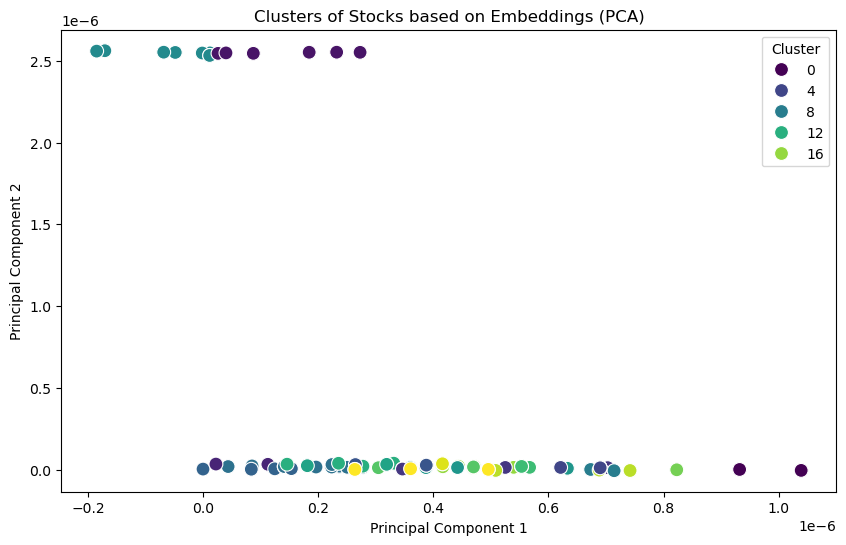

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Apply KMeans on the transformed data
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(cosine_sim_matrix)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(permno_ids, labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(permno_ids):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [40]:
cosine_sim_matrix

array([[1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       ...,
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001],
       [1.0000001, 1.0000001, 1.0000001, ..., 1.0000001, 1.0000001,
        1.0000001]], dtype=float32)

#### Model-2.1 (sector_weighted_avg_log_return)
Features:   
'log_return'  
'naics_sector_digits'  
'sector_weighted_avg_log_return'  
'+' 'postional encoding' 

In [71]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [72]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[["log_return", "naics_sector_digits", "sector_weighted_avg_log_return"]] = self.data[
            ["log_return", "naics_sector_digits", "sector_weighted_avg_log_return"]
        ].apply(pd.to_numeric, errors="coerce")
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "sector_weighted_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 3 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/2123244816.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits', 'sector_weighted_avg_log_return']] = self.data[


In [73]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [74]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [75]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.32908252,  0.8832298 , -0.8404978 ,  0.02179693, -1.0338604 ,
          1.2491218 , -0.60222435, -0.10692059,  1.7859334 , -1.6198052 ,
         -0.4393825 ,  1.7222664 , -0.43608737, -1.9393281 , -1.126297  ,
          0.0681786 ,  1.3250688 ,  0.7191264 , -0.09428919, -0.03703684,
          0.34276146,  0.23988913,  0.2505542 , -1.9848083 ,  1.1545149 ,
          0.11084883, -0.04313409,  0.6988482 , -0.46133462, -0.3236467 ,
         -0.5173874 ,  0.5815051 ,  0.21359074,  1.1761401 ,  0.7282802 ,
         -0.01925811,  1.0910348 ,  1.4609283 , -1.2947916 ,  0.8533574 ,
          1.2721318 ,  0.675759  ,  1.3437567 ,  1.3456286 , -1.1946776 ,
         -2.4252033 ,  0.2749655 ,  0.11257507,  0.9355289 , -2.0369658 ,
         -1.5932451 , -0.50327134, -0.9863844 ,  0.12665525, -0.27948344,
         -0.9725016 ,  0.3110192 ,  0.71242535, -1.8942884 ,  0.78439057,
         -0.17260428,  0.570321  , -0.05234281, -0.4402615 ], dtype=float32)),
 ('10107',
  array([ 0

##### Model Features Check

In [76]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  ...,  5.1000e+01,
         -3.7780e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  2.1973e-02,  ...,  5.1000e+01,
          7.1200e-04,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  2.9400e-03,  ...,  5.1000e+01,
          1.4945e-02,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01,  6.3800e-03,  ...,  3.1000e+01,
         -1.5170e-03,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -9.7000e-04,  ...,  3.1000e+01,
          2.3540e-03,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01,  6.4510e-03,  ...,  3.1000e+01,
          6.1800e-04,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [77]:
batch["features"].shape

torch.Size([64, 22])

In [78]:
batch["target"].shape

torch.Size([64])

In [79]:
len(batch["permno_id"])

64

In [80]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  2.2897e-02,  5.1000e+01,
          2.1973e-02,  9.8028e-03,  5.1000e+01,  2.9400e-03,  6.0010e-03,
          5.1000e+01,  1.5718e-02,  1.0467e-02,  5.1000e+01,  6.2670e-03,
          5.4969e-03,  5.1000e+01, -2.2500e-04, -5.3141e-03,  5.1000e+01,
         -3.7780e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  2.1973e-02,  9.8028e-03,  5.1000e+01,
          2.9400e-03,  6.0010e-03,  5.1000e+01,  1.5718e-02,  1.0467e-02,
          5.1000e+01,  6.2670e-03,  5.4969e-03,  5.1000e+01, -2.2500e-04,
         -5.3141e-03,  5.1000e+01, -3.7780e-03,  3.0693e-03,  5.1000e+01,
          7.1200e-04,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  2.9400e-03,  6.0010e-03,  5.1000e+01,
          1.5718e-02,  1.0467e-02,  5.1000e+01,  6.2670e-03,  5.4969e-03,
          5.1000e+01, -2.2500e-04, -5.3141e-03,  5.1000e+01, -3.7780e-03,
          3.0693e-03,  5.1000e+01,  7.1200e-04,  1.1375e-02,  5.1000e+01,
          1.4945e-02,  9.0000e+00],
    

In [65]:
model(batch["features"])

(tensor([-0.5941, -0.5915, -0.5889, -0.5862, -0.5837, -0.5810, -0.5786, -0.5760,
         -0.5735, -0.5709, -0.5683, -0.5659, -0.5632, -0.5609, -0.5941, -0.5915,
         -0.5889, -0.5862, -0.5837, -0.5810, -0.5786, -0.5760, -0.5734, -0.5709,
         -0.5683, -0.5659, -0.5633, -0.5608, -0.5946, -0.5921, -0.5895, -0.5869,
         -0.5845, -0.5818, -0.5795, -0.5768, -0.5744, -0.5718, -0.5694, -0.5670,
         -0.5644, -0.5621, -0.5888, -0.5858, -0.5828, -0.5797, -0.5767, -0.5736,
         -0.5707, -0.5675, -0.5646, -0.5614, -0.5584, -0.5552, -0.5518, -0.5487,
         -0.5792, -0.5754, -0.5713, -0.5675, -0.5634, -0.5592, -0.5552, -0.5510],
        grad_fn=<SqueezeBackward1>),
 tensor([[ 2.1420,  0.1578, -0.4972,  ..., -0.4875,  0.7256, -1.4171],
         [ 2.1445,  0.1521, -0.4982,  ..., -0.4940,  0.7255, -1.4174],
         [ 2.1471,  0.1465, -0.4991,  ..., -0.5003,  0.7255, -1.4177],
         ...,
         [ 2.2127,  0.1593, -0.4473,  ..., -0.5239,  0.6257, -1.3220],
         [ 2.213

In [81]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01,  0.00000000e+00,  2.28968548e-02,
          5.10000000e+01,  2.19730000e-02,  9.80279522e-03,  5.10000000e+01,
          2.94000000e-03,  6.00095818e-03,  5.10000000e+01,  1.57180000e-02,
          1.04670290e-02,  5.10000000e+01,  6.26700000e-03,  5.49686452e-03,
          5.10000000e+01, -2.25000000e-04, -5.31409482e-03,  5.10000000e+01,
         -3.77800000e-03,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01,  2.19730000e-02,  9.80279522e-03,
          5.10000000e+01,  2.94000000e-03,  6.00095818e-03,  5.10000000e+01,
          1.57180000e-02,  1.04670290e-02,  5.10000000e+01,  6.26700000e-03,
          5.49686452e-03,  5.10000000e+01, -2.25000000e-04, -5.31409482e-03,
          5.10000000e+01, -3.77800000e-03,  3.06928492e-03,  5.10000000e+01,
          7.12000000e-04,  8.00000000e+00]),
  0.0113750580215052,
  '10104'),
 (array([ 9.80279522e-03,  5.10000000e+01,  2.94000000e-03,  6.00095818e

In [82]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [83]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.2 (sector_simple_avg_log_return)
Features:   
'log_return'  
'naics_sector_digits'  
'sector_simple_avg_log_return'  
'+' 'postional encoding' 

In [84]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [85]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[["log_return", "naics_sector_digits", "sector_simple_avg_log_return"]] = self.data[
            ["log_return", "naics_sector_digits", "sector_simple_avg_log_return"]
        ].apply(pd.to_numeric, errors="coerce")
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "sector_simple_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 3 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/1361770126.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits', 'sector_simple_avg_log_return']] = self.data[


In [86]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [87]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [88]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 6.8111163e-01, -5.9833652e-01, -4.7851562e-01,  5.6906754e-01,
         -4.2524856e-01,  9.2252187e-02, -1.7363365e+00,  2.0333087e+00,
          1.5643828e-01, -8.5681355e-01,  6.7639059e-01,  8.3938636e-02,
         -1.3845514e+00,  9.6654540e-01,  7.7471399e-01,  1.3611041e+00,
         -7.9444200e-01, -1.4027397e-01, -5.1145095e-01,  1.0051315e-03,
          1.4331847e+00, -1.0756897e+00,  1.2221506e+00,  1.3438684e+00,
         -2.2313991e+00, -7.2735733e-01, -9.4778651e-01,  8.4356833e-01,
         -9.6958405e-01,  6.4076006e-01, -1.4322817e+00, -1.2689443e-01,
         -7.7516091e-01, -1.8330866e+00, -5.2233535e-01,  7.8743297e-01,
         -9.0371615e-01, -7.1203518e-01,  1.7774343e-01, -1.8110716e+00,
          2.8036168e-01,  1.3265971e+00,  9.6235436e-01, -1.5377685e-01,
          2.3848577e-01, -4.0120521e-01,  1.9878429e+00, -7.5994015e-01,
          9.8391712e-01, -5.7625389e-01,  1.2354888e+00,  1.5688479e-01,
         -4.7052121e-01, -8.8467544e-01,

##### Model Features Check

In [89]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  ...,  5.1000e+01,
          4.8410e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  5.6940e-03,  ...,  5.1000e+01,
          4.4800e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  1.6810e-03,  ...,  5.1000e+01,
          8.1390e-03,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01, -2.5460e-03,  ...,  3.1000e+01,
         -2.0573e-02,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -6.6320e-03,  ...,  3.1000e+01,
          2.4797e-02,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01,  1.3821e-02,  ...,  3.1000e+01,
         -1.1860e-03,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [90]:
batch["features"].shape

torch.Size([64, 22])

In [91]:
batch["target"].shape

torch.Size([64])

In [92]:
len(batch["permno_id"])

64

In [93]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  2.2897e-02,  5.1000e+01,
          5.6940e-03,  9.8028e-03,  5.1000e+01,  1.6810e-03,  6.0010e-03,
          5.1000e+01,  4.0050e-03,  1.0467e-02,  5.1000e+01,  9.7890e-03,
          5.4969e-03,  5.1000e+01, -4.9490e-03, -5.3141e-03,  5.1000e+01,
          4.8410e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  5.6940e-03,  9.8028e-03,  5.1000e+01,
          1.6810e-03,  6.0010e-03,  5.1000e+01,  4.0050e-03,  1.0467e-02,
          5.1000e+01,  9.7890e-03,  5.4969e-03,  5.1000e+01, -4.9490e-03,
         -5.3141e-03,  5.1000e+01,  4.8410e-03,  3.0693e-03,  5.1000e+01,
          4.4800e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  1.6810e-03,  6.0010e-03,  5.1000e+01,
          4.0050e-03,  1.0467e-02,  5.1000e+01,  9.7890e-03,  5.4969e-03,
          5.1000e+01, -4.9490e-03, -5.3141e-03,  5.1000e+01,  4.8410e-03,
          3.0693e-03,  5.1000e+01,  4.4800e-03,  1.1375e-02,  5.1000e+01,
          8.1390e-03,  9.0000e+00],
    

In [94]:
model(batch["features"])

(tensor([-0.8455, -0.8415, -0.8375, -0.8335, -0.8295, -0.8256, -0.8214, -0.8172,
         -0.8132, -0.8092, -0.8054, -0.8012, -0.7967, -0.7927, -0.8454, -0.8415,
         -0.8375, -0.8335, -0.8295, -0.8256, -0.8214, -0.8172, -0.8132, -0.8093,
         -0.8054, -0.8012, -0.7968, -0.7926, -0.8455, -0.8416, -0.8378, -0.8339,
         -0.8298, -0.8258, -0.8218, -0.8179, -0.8139, -0.8100, -0.8060, -0.8019,
         -0.7977, -0.7936, -0.8437, -0.8388, -0.8343, -0.8297, -0.8256, -0.8212,
         -0.8159, -0.8109, -0.8065, -0.8019, -0.7975, -0.7925, -0.7870, -0.7823,
         -0.8384, -0.8327, -0.8269, -0.8211, -0.8152, -0.8094, -0.8035, -0.7976],
        grad_fn=<SqueezeBackward1>),
 tensor([[ 0.6503, -0.6090, -0.4275,  ...,  2.1131,  1.2174, -0.4604],
         [ 0.6551, -0.6081, -0.4351,  ...,  2.1138,  1.2114, -0.4602],
         [ 0.6600, -0.6067, -0.4429,  ...,  2.1144,  1.2057, -0.4604],
         ...,
         [ 0.8276, -0.6514, -0.5578,  ...,  2.2633,  1.0505, -0.4844],
         [ 0.832

In [95]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01,  0.00000000e+00,  2.28968548e-02,
          5.10000000e+01,  5.69400000e-03,  9.80279522e-03,  5.10000000e+01,
          1.68100000e-03,  6.00095818e-03,  5.10000000e+01,  4.00500000e-03,
          1.04670290e-02,  5.10000000e+01,  9.78900000e-03,  5.49686452e-03,
          5.10000000e+01, -4.94900000e-03, -5.31409482e-03,  5.10000000e+01,
          4.84100000e-03,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01,  5.69400000e-03,  9.80279522e-03,
          5.10000000e+01,  1.68100000e-03,  6.00095818e-03,  5.10000000e+01,
          4.00500000e-03,  1.04670290e-02,  5.10000000e+01,  9.78900000e-03,
          5.49686452e-03,  5.10000000e+01, -4.94900000e-03, -5.31409482e-03,
          5.10000000e+01,  4.84100000e-03,  3.06928492e-03,  5.10000000e+01,
          4.48000000e-03,  8.00000000e+00]),
  0.0113750580215052,
  '10104'),
 (array([ 9.80279522e-03,  5.10000000e+01,  1.68100000e-03,  6.00095818e

In [96]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [97]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.3 (weighted_avg_log_return)
Features:   
'log_return'  
'naics_sector_digits'  
'weighted_avg_log_return'  
'+' 'postional encoding' 

In [98]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [99]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[["log_return", "naics_sector_digits", "weighted_avg_log_return"]] = self.data[
            ["log_return", "naics_sector_digits", "weighted_avg_log_return"]
        ].apply(pd.to_numeric, errors="coerce")
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "weighted_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 3 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/3234949662.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits', 'weighted_avg_log_return']] = self.data[


In [100]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [101]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [102]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.50589997,  0.3885665 ,  0.60001135, -0.36972338, -0.10675371,
         -1.1756622 ,  0.6982804 ,  0.96449584,  1.0398933 ,  0.8811446 ,
         -0.5374921 , -0.27195382, -0.94125515, -2.323974  ,  0.52680796,
         -0.64887637,  0.9884742 , -0.8911128 , -0.3002301 ,  0.11199079,
          0.14209132,  0.15102103, -0.4706656 ,  0.27543145, -2.6996396 ,
          0.31671935,  0.675705  ,  0.77352625,  0.8697481 , -0.6236788 ,
          0.7941457 ,  0.6194566 , -0.75870496, -0.39999914, -1.9479505 ,
          0.32229   ,  0.33261815,  0.55981123, -0.801843  , -1.0941914 ,
         -0.01959615, -0.41479108, -1.274932  , -1.0810653 ,  1.8189257 ,
          0.37861034, -0.747423  , -1.5385045 ,  2.1184602 ,  0.23228256,
         -2.6788824 , -1.6023449 ,  0.5970372 ,  0.7380081 ,  0.78594315,
          1.404137  ,  0.6686845 ,  1.0835203 ,  0.83448523,  0.68714905,
          0.56133157,  1.0175189 , -0.04306516,  0.29910854], dtype=float32)),
 ('10107',
  array([ 0

##### Model Features Check

In [103]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01, -0.0000e+00,  ...,  5.1000e+01,
         -0.0000e+00,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  0.0000e+00,  ...,  5.1000e+01,
          0.0000e+00,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  0.0000e+00,  ...,  5.1000e+01,
          0.0000e+00,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01,  0.0000e+00,  ...,  3.1000e+01,
         -0.0000e+00,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -0.0000e+00,  ...,  3.1000e+01,
          0.0000e+00,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01,  0.0000e+00,  ...,  3.1000e+01,
          0.0000e+00,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [104]:
batch["features"].shape

torch.Size([64, 22])

In [105]:
batch["target"].shape

torch.Size([64])

In [106]:
len(batch["permno_id"])

64

In [107]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01, -0.0000e+00,  2.2897e-02,  5.1000e+01,
          0.0000e+00,  9.8028e-03,  5.1000e+01,  0.0000e+00,  6.0010e-03,
          5.1000e+01,  0.0000e+00,  1.0467e-02,  5.1000e+01,  0.0000e+00,
          5.4969e-03,  5.1000e+01,  0.0000e+00, -5.3141e-03,  5.1000e+01,
         -0.0000e+00,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  0.0000e+00,  9.8028e-03,  5.1000e+01,
          0.0000e+00,  6.0010e-03,  5.1000e+01,  0.0000e+00,  1.0467e-02,
          5.1000e+01,  0.0000e+00,  5.4969e-03,  5.1000e+01,  0.0000e+00,
         -5.3141e-03,  5.1000e+01, -0.0000e+00,  3.0693e-03,  5.1000e+01,
          0.0000e+00,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  0.0000e+00,  6.0010e-03,  5.1000e+01,
          0.0000e+00,  1.0467e-02,  5.1000e+01,  0.0000e+00,  5.4969e-03,
          5.1000e+01,  0.0000e+00, -5.3141e-03,  5.1000e+01, -0.0000e+00,
          3.0693e-03,  5.1000e+01,  0.0000e+00,  1.1375e-02,  5.1000e+01,
          0.0000e+00,  9.0000e+00],
    

In [108]:
model(batch["features"])

(tensor([-0.0135, -0.0138, -0.0143, -0.0150, -0.0158, -0.0165, -0.0175, -0.0182,
         -0.0189, -0.0198, -0.0205, -0.0213, -0.0220, -0.0229, -0.0133, -0.0139,
         -0.0144, -0.0150, -0.0159, -0.0165, -0.0175, -0.0182, -0.0188, -0.0199,
         -0.0205, -0.0212, -0.0221, -0.0229, -0.0150, -0.0154, -0.0159, -0.0164,
         -0.0171, -0.0177, -0.0187, -0.0194, -0.0202, -0.0210, -0.0217, -0.0225,
         -0.0232, -0.0241,  0.0015,  0.0005, -0.0003, -0.0012, -0.0021, -0.0027,
         -0.0036, -0.0043, -0.0052, -0.0061, -0.0070, -0.0079, -0.0088, -0.0097,
          0.0334,  0.0319,  0.0310,  0.0296,  0.0287,  0.0277,  0.0265,  0.0256],
        grad_fn=<SqueezeBackward1>),
 tensor([[ 0.5018,  0.4120,  0.6515,  ...,  1.0159, -0.0530,  0.2976],
         [ 0.5027,  0.4082,  0.6435,  ...,  1.0163, -0.0514,  0.2984],
         [ 0.5037,  0.4046,  0.6354,  ...,  1.0167, -0.0500,  0.2991],
         ...,
         [ 0.5432,  0.4279,  0.4800,  ...,  0.9643, -0.1333,  0.3506],
         [ 0.542

In [109]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01, -0.00000000e+00,  2.28968548e-02,
          5.10000000e+01,  0.00000000e+00,  9.80279522e-03,  5.10000000e+01,
          0.00000000e+00,  6.00095818e-03,  5.10000000e+01,  0.00000000e+00,
          1.04670290e-02,  5.10000000e+01,  0.00000000e+00,  5.49686452e-03,
          5.10000000e+01,  0.00000000e+00, -5.31409482e-03,  5.10000000e+01,
         -0.00000000e+00,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01,  0.00000000e+00,  9.80279522e-03,
          5.10000000e+01,  0.00000000e+00,  6.00095818e-03,  5.10000000e+01,
          0.00000000e+00,  1.04670290e-02,  5.10000000e+01,  0.00000000e+00,
          5.49686452e-03,  5.10000000e+01,  0.00000000e+00, -5.31409482e-03,
          5.10000000e+01, -0.00000000e+00,  3.06928492e-03,  5.10000000e+01,
          0.00000000e+00,  8.00000000e+00]),
  0.0113750580215052,
  '10104'),
 (array([ 9.80279522e-03,  5.10000000e+01,  0.00000000e+00,  6.00095818e

In [110]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [111]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.4 (simple_avg_log_return)
Features:   
'log_return'  
'naics_sector_digits'  
'simple_avg_log_return'  
'+' 'postional encoding' 

In [112]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [113]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[["log_return", "naics_sector_digits", "simple_avg_log_return"]] = self.data[
            ["log_return", "naics_sector_digits", "simple_avg_log_return"]
        ].apply(pd.to_numeric, errors="coerce")
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "simple_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 3 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/411360817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits', 'simple_avg_log_return']] = self.data[


In [114]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [115]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [116]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.2171209 , -1.2565155 , -1.6900971 ,  0.88782203,  0.05599443,
          0.62638843, -0.6663399 ,  1.4921323 , -0.36332384, -0.77343625,
         -0.49693087,  1.9253645 ,  0.11037962, -2.1740942 , -0.42593625,
         -0.01888905, -1.0540392 ,  0.43162403, -0.8303494 , -0.4466519 ,
          1.200169  ,  0.35357404,  2.439891  , -1.5806366 ,  0.2313731 ,
          0.14968248, -0.5860244 , -0.4587985 ,  1.2851261 ,  1.7636526 ,
          0.34427193, -0.49704248, -0.79989564, -0.9971977 ,  0.55804026,
         -0.0072481 ,  1.7266722 , -0.11013879, -1.6149718 , -1.2499381 ,
          0.11996333, -0.6461863 , -0.7445633 ,  0.5519547 , -1.8995494 ,
          0.9887008 ,  0.01378122,  1.2556251 , -0.6788363 ,  0.8901144 ,
          0.19774726, -0.18774989,  0.18917319,  0.36447075, -1.5912737 ,
          0.9994582 ,  0.680396  , -0.89232343,  0.84321594,  1.1237696 ,
          0.7069427 , -0.6679557 ,  0.4843927 , -0.8004249 ], dtype=float32)),
 ('10107',
  array([ 1

##### Model Features Check

In [117]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01, -6.4000e-04,  ...,  5.1000e+01,
         -6.4000e-04,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01, -6.4000e-04,  ...,  5.1000e+01,
         -6.4000e-04,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01, -6.4000e-04,  ...,  5.1000e+01,
         -6.4000e-04,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01, -6.4000e-04,  ...,  3.1000e+01,
         -6.4000e-04,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -6.4000e-04,  ...,  3.1000e+01,
         -6.4000e-04,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01, -6.4000e-04,  ...,  3.1000e+01,
         -6.4000e-04,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [118]:
batch["features"].shape

torch.Size([64, 22])

In [119]:
batch["target"].shape

torch.Size([64])

In [120]:
len(batch["permno_id"])

64

In [121]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01, -6.4000e-04,  2.2897e-02,  5.1000e+01,
         -6.4000e-04,  9.8028e-03,  5.1000e+01, -6.4000e-04,  6.0010e-03,
          5.1000e+01, -6.4000e-04,  1.0467e-02,  5.1000e+01, -6.4000e-04,
          5.4969e-03,  5.1000e+01, -6.4000e-04, -5.3141e-03,  5.1000e+01,
         -6.4000e-04,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01, -6.4000e-04,  9.8028e-03,  5.1000e+01,
         -6.4000e-04,  6.0010e-03,  5.1000e+01, -6.4000e-04,  1.0467e-02,
          5.1000e+01, -6.4000e-04,  5.4969e-03,  5.1000e+01, -6.4000e-04,
         -5.3141e-03,  5.1000e+01, -6.4000e-04,  3.0693e-03,  5.1000e+01,
         -6.4000e-04,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01, -6.4000e-04,  6.0010e-03,  5.1000e+01,
         -6.4000e-04,  1.0467e-02,  5.1000e+01, -6.4000e-04,  5.4969e-03,
          5.1000e+01, -6.4000e-04, -5.3141e-03,  5.1000e+01, -6.4000e-04,
          3.0693e-03,  5.1000e+01, -6.4000e-04,  1.1375e-02,  5.1000e+01,
         -6.4000e-04,  9.0000e+00],
    

In [122]:
model(batch["features"])

(tensor([0.6117, 0.6105, 0.6092, 0.6079, 0.6066, 0.6053, 0.6039, 0.6026, 0.6012,
         0.5999, 0.5986, 0.5972, 0.5959, 0.5945, 0.6118, 0.6105, 0.6093, 0.6079,
         0.6066, 0.6053, 0.6038, 0.6027, 0.6012, 0.5999, 0.5986, 0.5972, 0.5959,
         0.5946, 0.6132, 0.6120, 0.6107, 0.6094, 0.6082, 0.6069, 0.6055, 0.6043,
         0.6028, 0.6016, 0.6002, 0.5990, 0.5976, 0.5963, 0.5957, 0.5941, 0.5927,
         0.5910, 0.5895, 0.5880, 0.5864, 0.5850, 0.5833, 0.5818, 0.5801, 0.5786,
         0.5769, 0.5753, 0.5675, 0.5657, 0.5635, 0.5611, 0.5590, 0.5567, 0.5547,
         0.5526], grad_fn=<SqueezeBackward1>),
 tensor([[ 1.2360, -1.2474, -1.6927,  ..., -0.6727,  0.4777, -0.7955],
         [ 1.2329, -1.2493, -1.6921,  ..., -0.6718,  0.4792, -0.7963],
         [ 1.2302, -1.2508, -1.6916,  ..., -0.6708,  0.4803, -0.7970],
         ...,
         [ 1.1793, -1.1822, -1.7002,  ..., -0.8130,  0.4610, -0.7509],
         [ 1.1747, -1.1838, -1.6989,  ..., -0.8118,  0.4625, -0.7509],
         [ 1.1701

In [123]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01, -6.40000000e-04,  2.28968548e-02,
          5.10000000e+01, -6.40000000e-04,  9.80279522e-03,  5.10000000e+01,
         -6.40000000e-04,  6.00095818e-03,  5.10000000e+01, -6.40000000e-04,
          1.04670290e-02,  5.10000000e+01, -6.40000000e-04,  5.49686452e-03,
          5.10000000e+01, -6.40000000e-04, -5.31409482e-03,  5.10000000e+01,
         -6.40000000e-04,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01, -6.40000000e-04,  9.80279522e-03,
          5.10000000e+01, -6.40000000e-04,  6.00095818e-03,  5.10000000e+01,
         -6.40000000e-04,  1.04670290e-02,  5.10000000e+01, -6.40000000e-04,
          5.49686452e-03,  5.10000000e+01, -6.40000000e-04, -5.31409482e-03,
          5.10000000e+01, -6.40000000e-04,  3.06928492e-03,  5.10000000e+01,
         -6.40000000e-04,  8.00000000e+00]),
  0.0113750580215052,
  '10104'),
 (array([ 9.80279522e-03,  5.10000000e+01, -6.40000000e-04,  6.00095818e

In [124]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [125]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.5 (cluster_weighted_avg_log_return)
Features:   
'log_return'  
'naics_sector_digits'  
'cluster_weighted_avg_log_return'  
'+' 'postional encoding' 

In [126]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [127]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[["log_return", "naics_sector_digits", "cluster_weighted_avg_log_return"]] = self.data[
            ["log_return", "naics_sector_digits", "cluster_weighted_avg_log_return"]
        ].apply(pd.to_numeric, errors="coerce")
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "cluster_weighted_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 3 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/2683425509.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits', 'cluster_weighted_avg_log_return']] = self.data[


In [128]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [129]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [130]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.2634251 ,  2.159774  ,  0.21307574, -0.18359968,  0.5858932 ,
         -0.07753217, -0.43670052,  1.1644843 , -0.12574743, -1.5867698 ,
          0.6170451 , -0.9387183 ,  1.3764038 ,  1.653097  ,  1.535806  ,
         -0.2698994 , -0.61309826, -0.14766762,  1.0308925 ,  0.15410885,
          0.06861847,  0.43361083, -0.04196364, -0.27148914, -1.7673913 ,
          0.24695621,  0.49399096, -0.44885188, -1.4094172 , -0.9820571 ,
         -3.151007  ,  0.4175041 , -1.1180471 ,  1.3354652 , -1.2121519 ,
         -1.8534136 , -0.56495893, -1.1997334 ,  0.3244608 , -0.52418643,
         -0.76950437,  0.77369994, -0.41515827, -0.26331168, -0.2069209 ,
         -0.02935042,  2.787887  ,  0.11771943,  0.90979606,  0.8799876 ,
         -0.32347932, -0.06620865,  0.59455395,  0.22754501, -1.0555736 ,
          0.10456167,  1.4723994 ,  0.45872113, -1.1375554 ,  0.92616016,
         -0.63587606,  0.3396968 ,  0.48662382, -0.3263557 ], dtype=float32)),
 ('10107',
  array([ 0

##### Model Features Check

In [131]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  ...,  5.1000e+01,
         -5.8380e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  1.4044e-02,  ...,  5.1000e+01,
          2.8950e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  3.1840e-03,  ...,  5.1000e+01,
          1.3771e-02,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01,  1.2600e-03,  ...,  3.1000e+01,
         -2.0110e-03,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -5.8380e-03,  ...,  3.1000e+01,
          8.6610e-03,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01,  2.8950e-03,  ...,  3.1000e+01,
          9.5010e-03,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [132]:
batch["features"].shape

torch.Size([64, 22])

In [133]:
batch["target"].shape

torch.Size([64])

In [134]:
len(batch["permno_id"])

64

In [135]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  2.2897e-02,  5.1000e+01,
          1.4044e-02,  9.8028e-03,  5.1000e+01,  3.1840e-03,  6.0010e-03,
          5.1000e+01,  1.2863e-02,  1.0467e-02,  5.1000e+01,  3.4730e-03,
          5.4969e-03,  5.1000e+01,  1.2600e-03, -5.3141e-03,  5.1000e+01,
         -5.8380e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  1.4044e-02,  9.8028e-03,  5.1000e+01,
          3.1840e-03,  6.0010e-03,  5.1000e+01,  1.2863e-02,  1.0467e-02,
          5.1000e+01,  3.4730e-03,  5.4969e-03,  5.1000e+01,  1.2600e-03,
         -5.3141e-03,  5.1000e+01, -5.8380e-03,  3.0693e-03,  5.1000e+01,
          2.8950e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  3.1840e-03,  6.0010e-03,  5.1000e+01,
          1.2863e-02,  1.0467e-02,  5.1000e+01,  3.4730e-03,  5.4969e-03,
          5.1000e+01,  1.2600e-03, -5.3141e-03,  5.1000e+01, -5.8380e-03,
          3.0693e-03,  5.1000e+01,  2.8950e-03,  1.1375e-02,  5.1000e+01,
          1.3771e-02,  9.0000e+00],
    

In [136]:
model(batch["features"])

(tensor([0.0208, 0.0201, 0.0197, 0.0192, 0.0185, 0.0183, 0.0178, 0.0172, 0.0165,
         0.0158, 0.0152, 0.0145, 0.0139, 0.0129, 0.0205, 0.0202, 0.0196, 0.0191,
         0.0185, 0.0183, 0.0177, 0.0171, 0.0166, 0.0160, 0.0150, 0.0145, 0.0139,
         0.0128, 0.0182, 0.0176, 0.0171, 0.0166, 0.0158, 0.0156, 0.0149, 0.0144,
         0.0137, 0.0131, 0.0123, 0.0118, 0.0110, 0.0100, 0.0483, 0.0480, 0.0473,
         0.0471, 0.0465, 0.0461, 0.0454, 0.0449, 0.0443, 0.0437, 0.0431, 0.0425,
         0.0420, 0.0411, 0.0945, 0.0942, 0.0938, 0.0937, 0.0933, 0.0931, 0.0926,
         0.0921], grad_fn=<SqueezeBackward1>),
 tensor([[ 0.2748,  2.1500,  0.1828,  ...,  0.3399,  0.4937, -0.3188],
         [ 0.2729,  2.1513,  0.1872,  ...,  0.3400,  0.4925, -0.3201],
         [ 0.2712,  2.1531,  0.1920,  ...,  0.3399,  0.4913, -0.3211],
         ...,
         [ 0.1890,  2.0560,  0.2060,  ...,  0.2533,  0.4081, -0.3139],
         [ 0.1870,  2.0588,  0.2116,  ...,  0.2542,  0.4068, -0.3158],
         [ 0.1846

In [137]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01,  0.00000000e+00,  2.28968548e-02,
          5.10000000e+01,  1.40440000e-02,  9.80279522e-03,  5.10000000e+01,
          3.18400000e-03,  6.00095818e-03,  5.10000000e+01,  1.28630000e-02,
          1.04670290e-02,  5.10000000e+01,  3.47300000e-03,  5.49686452e-03,
          5.10000000e+01,  1.26000000e-03, -5.31409482e-03,  5.10000000e+01,
         -5.83800000e-03,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01,  1.40440000e-02,  9.80279522e-03,
          5.10000000e+01,  3.18400000e-03,  6.00095818e-03,  5.10000000e+01,
          1.28630000e-02,  1.04670290e-02,  5.10000000e+01,  3.47300000e-03,
          5.49686452e-03,  5.10000000e+01,  1.26000000e-03, -5.31409482e-03,
          5.10000000e+01, -5.83800000e-03,  3.06928492e-03,  5.10000000e+01,
          2.89500000e-03,  8.00000000e+00]),
  0.0113750580215052,
  '10104'),
 (array([ 9.80279522e-03,  5.10000000e+01,  3.18400000e-03,  6.00095818e

In [138]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [139]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.6 (cluster_simple_avg_log_return)
Features:   
'log_return'  
'naics_sector_digits'  
'cluster_simple_avg_log_return'  
'+' 'postional encoding' 

In [140]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [141]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[["log_return", "naics_sector_digits", "cluster_simple_avg_log_return"]] = self.data[
            ["log_return", "naics_sector_digits", "cluster_simple_avg_log_return"]
        ].apply(pd.to_numeric, errors="coerce")
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "cluster_simple_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 3 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/2312438891.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits', 'cluster_simple_avg_log_return']] = self.data[


In [142]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [143]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [144]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-0.38951272,  1.0187088 ,  0.77119   ,  0.5066704 , -0.7871334 ,
          0.96964884,  0.07014289, -0.15914103, -0.87205774,  0.15344366,
          0.45412686,  1.5673915 ,  0.36199063,  0.216416  , -0.2831333 ,
         -2.8602614 ,  0.9030995 , -1.4851149 ,  0.5135556 ,  1.3632795 ,
          0.01382374, -0.62323916, -0.7994841 , -2.017422  ,  2.3701828 ,
          0.00869121, -1.0908748 ,  1.4560264 ,  1.1910012 , -0.13233127,
          0.286475  ,  0.10739455, -1.6534188 ,  1.2926577 ,  0.5240899 ,
          0.82025605, -0.16747865,  1.117189  ,  0.34723753,  0.04071968,
          0.4974273 ,  0.6481338 , -1.0319046 , -1.6318448 ,  1.1685506 ,
         -1.484623  ,  1.0590924 , -1.0813392 ,  0.19159207,  1.194554  ,
         -0.19579373,  0.09613694,  0.08662685, -0.09392189, -0.74737346,
          0.30470514, -0.9087611 , -0.1456649 , -1.8078297 ,  0.6217395 ,
          0.03478658,  0.31193632, -0.2280352 , -1.9838064 ], dtype=float32)),
 ('10107',
  array([-0

##### Model Features Check

In [145]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  ...,  5.1000e+01,
         -9.3480e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  9.0190e-03,  ...,  5.1000e+01,
          7.8890e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  1.6850e-03,  ...,  5.1000e+01,
          6.6740e-03,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01,  3.3490e-03,  ...,  3.1000e+01,
         -3.9690e-03,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -9.3480e-03,  ...,  3.1000e+01,
          1.1555e-02,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01,  7.8890e-03,  ...,  3.1000e+01,
          2.2040e-03,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [146]:
batch["features"].shape

torch.Size([64, 22])

In [147]:
batch["target"].shape

torch.Size([64])

In [148]:
len(batch["permno_id"])

64

In [149]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  2.2897e-02,  5.1000e+01,
          9.0190e-03,  9.8028e-03,  5.1000e+01,  1.6850e-03,  6.0010e-03,
          5.1000e+01,  7.9370e-03,  1.0467e-02,  5.1000e+01,  4.6650e-03,
          5.4969e-03,  5.1000e+01,  3.3490e-03, -5.3141e-03,  5.1000e+01,
         -9.3480e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  9.0190e-03,  9.8028e-03,  5.1000e+01,
          1.6850e-03,  6.0010e-03,  5.1000e+01,  7.9370e-03,  1.0467e-02,
          5.1000e+01,  4.6650e-03,  5.4969e-03,  5.1000e+01,  3.3490e-03,
         -5.3141e-03,  5.1000e+01, -9.3480e-03,  3.0693e-03,  5.1000e+01,
          7.8890e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  1.6850e-03,  6.0010e-03,  5.1000e+01,
          7.9370e-03,  1.0467e-02,  5.1000e+01,  4.6650e-03,  5.4969e-03,
          5.1000e+01,  3.3490e-03, -5.3141e-03,  5.1000e+01, -9.3480e-03,
          3.0693e-03,  5.1000e+01,  7.8890e-03,  1.1375e-02,  5.1000e+01,
          6.6740e-03,  9.0000e+00],
    

In [150]:
model(batch["features"])

(tensor([0.1683, 0.1704, 0.1725, 0.1743, 0.1764, 0.1785, 0.1809, 0.1838, 0.1870,
         0.1908, 0.1943, 0.1976, 0.1999, 0.2022, 0.1685, 0.1704, 0.1725, 0.1743,
         0.1764, 0.1785, 0.1809, 0.1838, 0.1870, 0.1907, 0.1943, 0.1976, 0.1999,
         0.2021, 0.1696, 0.1717, 0.1737, 0.1755, 0.1776, 0.1797, 0.1820, 0.1846,
         0.1877, 0.1913, 0.1949, 0.1984, 0.2010, 0.2031, 0.1528, 0.1551, 0.1576,
         0.1601, 0.1632, 0.1664, 0.1701, 0.1740, 0.1776, 0.1806, 0.1828, 0.1849,
         0.1867, 0.1885, 0.1217, 0.1256, 0.1302, 0.1357, 0.1407, 0.1446, 0.1480,
         0.1508], grad_fn=<SqueezeBackward1>),
 tensor([[-0.3841,  1.0091,  0.7696,  ...,  0.3259, -0.2263, -1.9859],
         [-0.3849,  1.0105,  0.7692,  ...,  0.3245, -0.2254, -1.9839],
         [-0.3860,  1.0119,  0.7686,  ...,  0.3231, -0.2242, -1.9820],
         ...,
         [-0.4413,  0.9085,  0.7580,  ...,  0.3002, -0.1968, -1.9123],
         [-0.4417,  0.9106,  0.7590,  ...,  0.2968, -0.1975, -1.9131],
         [-0.4423

In [151]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01,  0.00000000e+00,  2.28968548e-02,
          5.10000000e+01,  9.01900000e-03,  9.80279522e-03,  5.10000000e+01,
          1.68500000e-03,  6.00095818e-03,  5.10000000e+01,  7.93700000e-03,
          1.04670290e-02,  5.10000000e+01,  4.66500000e-03,  5.49686452e-03,
          5.10000000e+01,  3.34900000e-03, -5.31409482e-03,  5.10000000e+01,
         -9.34800000e-03,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01,  9.01900000e-03,  9.80279522e-03,
          5.10000000e+01,  1.68500000e-03,  6.00095818e-03,  5.10000000e+01,
          7.93700000e-03,  1.04670290e-02,  5.10000000e+01,  4.66500000e-03,
          5.49686452e-03,  5.10000000e+01,  3.34900000e-03, -5.31409482e-03,
          5.10000000e+01, -9.34800000e-03,  3.06928492e-03,  5.10000000e+01,
          7.88900000e-03,  8.00000000e+00]),
  0.0113750580215052,
  '10104'),
 (array([ 9.80279522e-03,  5.10000000e+01,  1.68500000e-03,  6.00095818e

In [152]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [153]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.7 (weighted return)
Features:  
'log_return'  
'naics_sector_digits'  
'sector_weighted_avg_log_return'  
'weighted_avg_log_return'  
'cluster_weighted_avg_log_return'  
'+' 'postional encoding'  

In [167]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [168]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[
            [
                "log_return",
                "naics_sector_digits",
                "sector_weighted_avg_log_return",
                "weighted_avg_log_return",
                "cluster_weighted_avg_log_return",
            ]
        ] = self.data[
            [
                "log_return",
                "naics_sector_digits",
                "sector_weighted_avg_log_return",
                "weighted_avg_log_return",
                "cluster_weighted_avg_log_return",
            ]
        ].apply(
            pd.to_numeric, errors="coerce"
        )
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "sector_weighted_avg_log_return",
                                "weighted_avg_log_return",
                                "cluster_weighted_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 5 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/1514733330.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits', 'sector_weighted_avg_log_return',


In [169]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [170]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [172]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.08996735, -0.66603595,  1.4954702 ,  1.8296204 ,  0.40665025,
          1.1896887 , -0.2230649 ,  0.10597182,  0.65639055, -0.06760239,
          0.19806838,  1.6195202 , -1.0712649 , -0.02009724, -0.6481008 ,
          0.5622963 , -0.5812573 ,  1.4029028 , -1.249656  ,  0.1011893 ,
          0.17374994, -0.14050332,  0.02087441,  0.3149268 ,  0.12777618,
         -0.17158937, -1.0688597 , -1.1863464 , -0.22168973, -1.1814871 ,
         -2.267266  ,  0.21254596,  0.8051612 , -1.6245033 ,  0.43447113,
         -1.4282521 , -1.1655056 ,  0.59065217, -1.198353  , -0.19013152,
          0.865436  ,  1.2536899 ,  1.7946701 , -1.062378  ,  0.1240694 ,
          0.02099835,  2.355205  , -0.23315792,  0.5193702 ,  1.5320567 ,
          0.13600452, -0.9599963 , -0.5976362 ,  1.223814  ,  1.7736157 ,
         -1.2206476 , -0.47871664, -1.211707  ,  0.3093864 , -1.4821028 ,
         -1.429106  , -0.37798086,  0.2907197 ,  0.88868326], dtype=float32)),
 ('10107',
  array([ 0

##### Model Features Check

In [173]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  ..., -0.0000e+00,
         -5.8380e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  2.1973e-02,  ...,  0.0000e+00,
          2.8950e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  2.9400e-03,  ...,  0.0000e+00,
          1.3771e-02,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01,  6.3800e-03,  ..., -0.0000e+00,
         -2.0110e-03,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -9.7000e-04,  ...,  0.0000e+00,
          8.6610e-03,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01,  6.4510e-03,  ...,  0.0000e+00,
          9.5010e-03,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [174]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00, -0.0000e+00,  0.0000e+00,
          2.2897e-02,  5.1000e+01,  2.1973e-02,  0.0000e+00,  1.4044e-02,
          9.8028e-03,  5.1000e+01,  2.9400e-03,  0.0000e+00,  3.1840e-03,
          6.0010e-03,  5.1000e+01,  1.5718e-02,  0.0000e+00,  1.2863e-02,
          1.0467e-02,  5.1000e+01,  6.2670e-03,  0.0000e+00,  3.4730e-03,
          5.4969e-03,  5.1000e+01, -2.2500e-04,  0.0000e+00,  1.2600e-03,
         -5.3141e-03,  5.1000e+01, -3.7780e-03, -0.0000e+00, -5.8380e-03,
          7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  2.1973e-02,  0.0000e+00,  1.4044e-02,
          9.8028e-03,  5.1000e+01,  2.9400e-03,  0.0000e+00,  3.1840e-03,
          6.0010e-03,  5.1000e+01,  1.5718e-02,  0.0000e+00,  1.2863e-02,
          1.0467e-02,  5.1000e+01,  6.2670e-03,  0.0000e+00,  3.4730e-03,
          5.4969e-03,  5.1000e+01, -2.2500e-04,  0.0000e+00,  1.2600e-03,
         -5.3141e-03,  5.1000e+01, -3.7780e-03, -0.0000e+00, -5.8380e-03,
          3.069

In [175]:
model(batch["features"])

(tensor([0.0238, 0.0233, 0.0227, 0.0222, 0.0218, 0.0216, 0.0212, 0.0208, 0.0203,
         0.0201, 0.0197, 0.0195, 0.0191, 0.0190, 0.0237, 0.0233, 0.0227, 0.0222,
         0.0219, 0.0216, 0.0212, 0.0209, 0.0202, 0.0201, 0.0196, 0.0195, 0.0192,
         0.0190, 0.0226, 0.0222, 0.0216, 0.0212, 0.0208, 0.0206, 0.0203, 0.0198,
         0.0194, 0.0191, 0.0188, 0.0184, 0.0180, 0.0179, 0.0374, 0.0368, 0.0361,
         0.0354, 0.0350, 0.0346, 0.0340, 0.0337, 0.0332, 0.0328, 0.0325, 0.0321,
         0.0317, 0.0316, 0.0618, 0.0612, 0.0602, 0.0598, 0.0588, 0.0582, 0.0574,
         0.0566], grad_fn=<SqueezeBackward1>),
 tensor([[ 0.0808, -0.6941,  1.4888,  ..., -0.3968,  0.2666,  0.9134],
         [ 0.0819, -0.6898,  1.4898,  ..., -0.3939,  0.2704,  0.9092],
         [ 0.0829, -0.6857,  1.4908,  ..., -0.3909,  0.2746,  0.9051],
         ...,
         [ 0.1859, -0.7496,  1.5473,  ..., -0.3947,  0.2092,  0.9157],
         [ 0.1866, -0.7432,  1.5485,  ..., -0.3901,  0.2143,  0.9097],
         [ 0.1880

In [176]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00,  2.28968548e-02,  5.10000000e+01,  2.19730000e-02,
          0.00000000e+00,  1.40440000e-02,  9.80279522e-03,  5.10000000e+01,
          2.94000000e-03,  0.00000000e+00,  3.18400000e-03,  6.00095818e-03,
          5.10000000e+01,  1.57180000e-02,  0.00000000e+00,  1.28630000e-02,
          1.04670290e-02,  5.10000000e+01,  6.26700000e-03,  0.00000000e+00,
          3.47300000e-03,  5.49686452e-03,  5.10000000e+01, -2.25000000e-04,
          0.00000000e+00,  1.26000000e-03, -5.31409482e-03,  5.10000000e+01,
         -3.77800000e-03, -0.00000000e+00, -5.83800000e-03,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01,  2.19730000e-02,  0.00000000e+00,
          1.40440000e-02,  9.80279522e-03,  5.10000000e+01,  2.94000000e-03,
          0.00000000e+00,  3.18400000e-03,  6.00095818e-03,  5.10000000e+01,
          1.57180000e-02,  0.00000000e+0

In [177]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [178]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.8 (simple return)
Features:  
'log_return'  
'naics_sector_digits'  
'sector_simple_avg_log_return'  
'simple_avg_log_return'  
'cluster_simple_avg_log_return'  
'+' 'postional encoding'  

In [179]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [180]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data[
            [
                "log_return",
                "naics_sector_digits",
                "sector_simple_avg_log_return",
                "simple_avg_log_return",
                "cluster_simple_avg_log_return",
            ]
        ] = self.data[
            [
                "log_return",
                "naics_sector_digits",
                "sector_simple_avg_log_return",
                "simple_avg_log_return",
                "cluster_simple_avg_log_return",
            ]
        ].apply(
            pd.to_numeric, errors="coerce"
        )
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "sector_simple_avg_log_return",
                                "simple_avg_log_return",
                                "cluster_simple_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
dataset = FinancialDataset(first_month_data[:100])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 * 5 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


/tmp/ipykernel_168/1511428079.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[['log_return', 'naics_sector_digits',


In [181]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [182]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [184]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 4.1117486e-01,  3.0830345e-01,  3.3412012e-01,  4.9053472e-01,
          1.7737328e+00,  5.4999232e-01,  8.6319104e-02,  3.5450697e-01,
          1.3384572e-01,  7.0476359e-01, -3.1063747e-01, -2.3342411e-01,
         -2.7802259e-01,  1.1061356e+00, -1.5058185e+00, -3.0847678e-01,
         -5.2381814e-01, -3.5948750e-01, -6.2645429e-01,  1.1041666e+00,
         -1.9097720e+00,  2.5839192e-01,  5.1212031e-01, -1.5058504e+00,
          2.1246240e+00, -9.4836378e-01, -1.9264344e+00,  6.2031138e-01,
          4.6953160e-01, -1.6375825e+00,  3.5975885e-02, -3.3210468e-01,
          1.9742061e+00, -2.3435473e+00,  4.2212777e-02,  1.2004946e+00,
         -7.6561165e-01,  1.8824673e+00, -1.3702615e-01, -2.6486769e-01,
          8.2392132e-01, -1.3910059e+00, -4.8056766e-01, -1.6329182e+00,
         -8.7263934e-02,  3.3960062e-01, -6.2936515e-01, -1.1638029e+00,
         -4.3503132e-01,  1.9585228e+00, -7.1156722e-01, -5.6783623e-01,
          6.8813783e-01, -1.0914696e+00,

##### Model Features Check

In [185]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00,  ..., -6.4000e-04,
         -9.3480e-03,  7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  5.6940e-03,  ..., -6.4000e-04,
          7.8890e-03,  8.0000e+00],
        [ 9.8028e-03,  5.1000e+01,  1.6810e-03,  ..., -6.4000e-04,
          6.6740e-03,  9.0000e+00],
        ...,
        [ 3.2378e-03,  3.1000e+01, -2.5460e-03,  ..., -6.4000e-04,
         -3.9690e-03,  1.2000e+01],
        [-7.7379e-03,  3.1000e+01, -6.6320e-03,  ..., -6.4000e-04,
          1.1555e-02,  1.3000e+01],
        [ 1.6156e-02,  3.1000e+01,  1.3821e-02,  ..., -6.4000e-04,
          2.2040e-03,  1.4000e+01]]), 'target': tensor([ 0.0031,  0.0114,  0.0016,  0.0136, -0.0008,  0.0069,  0.0026,  0.0081,
         0.0064,  0.0029,  0.0220, -0.0155, -0.0190,  0.0123,  0.0030,  0.0171,
        -0.0140,  0.0201, -0.0004, -0.0011,  0.0177,  0.0032, -0.0009,  0.0055,
         0.0186, -0.0015, -0.0126,  0.0242,  0.0070,  0.0201, -0.0077,  0.0165,
        -0.0051,  0.0134

In [186]:
batch["features"][:5]

tensor([[-1.3843e-02,  5.1000e+01,  0.0000e+00, -6.4000e-04,  0.0000e+00,
          2.2897e-02,  5.1000e+01,  5.6940e-03, -6.4000e-04,  9.0190e-03,
          9.8028e-03,  5.1000e+01,  1.6810e-03, -6.4000e-04,  1.6850e-03,
          6.0010e-03,  5.1000e+01,  4.0050e-03, -6.4000e-04,  7.9370e-03,
          1.0467e-02,  5.1000e+01,  9.7890e-03, -6.4000e-04,  4.6650e-03,
          5.4969e-03,  5.1000e+01, -4.9490e-03, -6.4000e-04,  3.3490e-03,
         -5.3141e-03,  5.1000e+01,  4.8410e-03, -6.4000e-04, -9.3480e-03,
          7.0000e+00],
        [ 2.2897e-02,  5.1000e+01,  5.6940e-03, -6.4000e-04,  9.0190e-03,
          9.8028e-03,  5.1000e+01,  1.6810e-03, -6.4000e-04,  1.6850e-03,
          6.0010e-03,  5.1000e+01,  4.0050e-03, -6.4000e-04,  7.9370e-03,
          1.0467e-02,  5.1000e+01,  9.7890e-03, -6.4000e-04,  4.6650e-03,
          5.4969e-03,  5.1000e+01, -4.9490e-03, -6.4000e-04,  3.3490e-03,
         -5.3141e-03,  5.1000e+01,  4.8410e-03, -6.4000e-04, -9.3480e-03,
          3.069

In [187]:
model(batch["features"])

(tensor([1.0208, 1.0193, 1.0178, 1.0164, 1.0144, 1.0130, 1.0112, 1.0095, 1.0078,
         1.0059, 1.0042, 1.0024, 1.0009, 0.9990, 1.0208, 1.0193, 1.0178, 1.0164,
         1.0145, 1.0130, 1.0113, 1.0094, 1.0078, 1.0059, 1.0041, 1.0024, 1.0008,
         0.9989, 1.0218, 1.0204, 1.0189, 1.0174, 1.0156, 1.0141, 1.0123, 1.0104,
         1.0089, 1.0071, 1.0055, 1.0036, 1.0021, 1.0003, 1.0086, 1.0078, 1.0057,
         1.0047, 1.0021, 1.0008, 0.9993, 0.9977, 0.9954, 0.9940, 0.9912, 0.9899,
         0.9870, 0.9847, 0.9817, 0.9796, 0.9778, 0.9758, 0.9734, 0.9713, 0.9682,
         0.9654], grad_fn=<SqueezeBackward1>),
 tensor([[ 0.3765,  0.3125,  0.3249,  ..., -0.4469, -0.8216,  0.1438],
         [ 0.3815,  0.3120,  0.3265,  ..., -0.4452, -0.8184,  0.1438],
         [ 0.3865,  0.3114,  0.3278,  ..., -0.4434, -0.8154,  0.1443],
         ...,
         [ 0.6679,  0.2288,  0.3563,  ..., -0.4312, -0.8754,  0.3722],
         [ 0.6765,  0.2274,  0.3591,  ..., -0.4283, -0.8707,  0.3713],
         [ 0.6856

In [188]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  5.10000000e+01,  0.00000000e+00, -6.40000000e-04,
          0.00000000e+00,  2.28968548e-02,  5.10000000e+01,  5.69400000e-03,
         -6.40000000e-04,  9.01900000e-03,  9.80279522e-03,  5.10000000e+01,
          1.68100000e-03, -6.40000000e-04,  1.68500000e-03,  6.00095818e-03,
          5.10000000e+01,  4.00500000e-03, -6.40000000e-04,  7.93700000e-03,
          1.04670290e-02,  5.10000000e+01,  9.78900000e-03, -6.40000000e-04,
          4.66500000e-03,  5.49686452e-03,  5.10000000e+01, -4.94900000e-03,
         -6.40000000e-04,  3.34900000e-03, -5.31409482e-03,  5.10000000e+01,
          4.84100000e-03, -6.40000000e-04, -9.34800000e-03,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  5.10000000e+01,  5.69400000e-03, -6.40000000e-04,
          9.01900000e-03,  9.80279522e-03,  5.10000000e+01,  1.68100000e-03,
         -6.40000000e-04,  1.68500000e-03,  6.00095818e-03,  5.10000000e+01,
          4.00500000e-03, -6.40000000e-0

In [189]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [190]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
5,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064,0.001260,0.003349
6,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064,-0.005838,-0.009348
7,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064,0.002895,0.007889
8,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064,0.013771,0.006674
9,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064,-0.001985,-0.004781


#### Model-2.10 (all returns)
Features:  
'log_return'  
'naics_sector_digits'  
'sector_weighted_avg_log_return'  
'sector_simple_avg_log_return'  
'weighted_avg_log_return'  
'simple_avg_log_return'  
'cluster_weighted_avg_log_return'  
'cluster_simple_avg_log_return'  
'+' 'postional encoding'  

In [154]:
first_month_data[:100]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064,0.000000,0.000000
1,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064,0.014044,0.009019
2,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064,0.003184,0.001685
3,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064,0.012863,0.007937
4,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064,0.003473,0.004665
...,...,...,...,...,...,...,...,...,...,...
6047,2018-01-18,10516,31,-0.010567,-0.001517,-0.020573,-0.0,-0.00064,-0.002011,-0.003969
6048,2018-01-19,10516,31,0.011788,0.002354,0.024797,0.0,-0.00064,0.008661,0.011555
6049,2018-01-22,10516,31,0.042773,0.000618,-0.001186,0.0,-0.00064,0.009501,0.002204
6050,2018-01-23,10516,31,-0.003280,-0.000947,-0.005879,-0.0,-0.00064,0.007779,0.001156


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128):
        self.data = data
        self.window_size = window_size
        self.data[
            [
                "log_return",
                "naics_sector_digits",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
                "cluster_weighted_avg_log_return",
                "cluster_simple_avg_log_return",
            ]
        ] = self.data[
            [
                "log_return",
                "naics_sector_digits",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
                "cluster_weighted_avg_log_return",
                "cluster_simple_avg_log_return",
            ]
        ].apply(
            pd.to_numeric, errors="coerce"
        )
        # self.data['log_return'] = pd.to_numeric(self.data['log_return'], errors='coerce')
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    # X = group['log_return'].iloc[i:i+self.window_size].values
                    X = (
                        group[
                            [
                                "log_return",
                                "naics_sector_digits",
                                "sector_weighted_avg_log_return",
                                "sector_simple_avg_log_return",
                                "weighted_avg_log_return",
                                "simple_avg_log_return",
                                "cluster_weighted_avg_log_return",
                                "cluster_simple_avg_log_return",
                            ]
                        ]
                        .iloc[i : i + self.window_size]
                        .values.flatten()
                    )
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
# dataset = FinancialDataset(first_month_data[:100])
# dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize Model
model = TransformerModel(input_dim=128 * 8 + 1, embed_dim=256, n_heads=16, ff_dim=1024, n_layers=6)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

# for epoch in range(1):
#     for batch in dataloader:
#         optimizer.zero_grad()
#         output, _ = model(batch["features"])
#         loss = criterion(output, batch["target"])
#         # print(f'loss: {loss}')
#         loss.backward()
#         optimizer.step()

# print("Training Complete")

train_losses = []
val_losses = []

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"])
            loss = criterion(output, batch["target"])
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

/tmp/ipykernel_163/4039292360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[
/tmp/ipykernel_163/4039292360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[


Epoch 1/3, Training Loss: nan, Validation Loss: nan


In [ ]:
dataloader = train_dataloader
dataset = train_dataset

In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
list(stock_embeddings.items())[:2]

##### Model Features Check

In [ ]:
for batch in dataloader:
    print(batch)
    break

In [ ]:
batch["features"][:5]

In [ ]:
model(batch["features"])

In [ ]:
dataset.sequences[:5]

In [ ]:
np.array(stock_embeddings["10104"]).shape

In [ ]:
first_month_data[first_month_data["permno_id"] == "10104"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Apply KMeans on the transformed data
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(cosine_sim_matrix)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(permno_ids, labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(permno_ids):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [ ]:
cosine_sim_matrix